In [108]:
from sympy import gruntz


base_path = "D:/code/datasets/recognizing_emotions_from_faces"
oryginal_data_path = f"{base_path}/oryginal_data"
duplicates_data_path = f"{base_path}/duplicates"
data_without_duplicates_path = f"{base_path}/data_without_duplicates"
data_path = f"{base_path}/data"

In [2]:
import kagglehub
import os
import shutil

path = kagglehub.dataset_download("msambare/fer2013")
os.makedirs(base_path, exist_ok=True)
destination_path = os.path.join(base_path, os.path.basename(path))
shutil.move(path, destination_path)
print("Pliki zostały zapisane w:", destination_path)

100%|██████████| 60.3M/60.3M [00:04<00:00, 15.8MB/s]

Extracting files...


Pliki zostały zapisane w: D:/code/datasets/recognizing_emotions_from_faces\1


Połączyłem foldery TEST oraz TRAIN

In [26]:
classes_path = os.walk(base_path)
print("Ilość \t|\t\t\tŚcieżka")
for root, dirs, files in classes_path:
    if len(files) > 0:
        print(f'{len(files)} \t|\t {root}')
        if root.endswith("surprise"):
            print(80*"-")

Ilość 	|			Ścieżka
958 	|	 D:/code/datasets/recognizing_emotions_from_faces\1\test\angry
111 	|	 D:/code/datasets/recognizing_emotions_from_faces\1\test\disgust
1024 	|	 D:/code/datasets/recognizing_emotions_from_faces\1\test\fear
1774 	|	 D:/code/datasets/recognizing_emotions_from_faces\1\test\happy
1233 	|	 D:/code/datasets/recognizing_emotions_from_faces\1\test\neutral
1247 	|	 D:/code/datasets/recognizing_emotions_from_faces\1\test\sad
831 	|	 D:/code/datasets/recognizing_emotions_from_faces\1\test\surprise
--------------------------------------------------------------------------------
3995 	|	 D:/code/datasets/recognizing_emotions_from_faces\1\train\angry
436 	|	 D:/code/datasets/recognizing_emotions_from_faces\1\train\disgust
4097 	|	 D:/code/datasets/recognizing_emotions_from_faces\1\train\fear
7215 	|	 D:/code/datasets/recognizing_emotions_from_faces\1\train\happy
4965 	|	 D:/code/datasets/recognizing_emotions_from_faces\1\train\neutral
4830 	|	 D:/code/datasets/recognizing_em

In [32]:
classes_path = os.walk(base_path)
for root, dirs, files in classes_path:
    if len(files) > 0:
        class_name = os.path.basename(root)
        print(f'{class_name}\t|\t {root}')
        shutil.copytree(os.path.join(root), os.path.join(oryginal_data_path, class_name, ), dirs_exist_ok=True)

angry	|	 D:/code/datasets/recognizing_emotions_from_faces\1\test\angry
disgust	|	 D:/code/datasets/recognizing_emotions_from_faces\1\test\disgust
fear	|	 D:/code/datasets/recognizing_emotions_from_faces\1\test\fear
happy	|	 D:/code/datasets/recognizing_emotions_from_faces\1\test\happy
neutral	|	 D:/code/datasets/recognizing_emotions_from_faces\1\test\neutral
sad	|	 D:/code/datasets/recognizing_emotions_from_faces\1\test\sad
surprise	|	 D:/code/datasets/recognizing_emotions_from_faces\1\test\surprise
angry	|	 D:/code/datasets/recognizing_emotions_from_faces\1\train\angry
disgust	|	 D:/code/datasets/recognizing_emotions_from_faces\1\train\disgust
fear	|	 D:/code/datasets/recognizing_emotions_from_faces\1\train\fear
happy	|	 D:/code/datasets/recognizing_emotions_from_faces\1\train\happy
neutral	|	 D:/code/datasets/recognizing_emotions_from_faces\1\train\neutral
sad	|	 D:/code/datasets/recognizing_emotions_from_faces\1\train\sad
surprise	|	 D:/code/datasets/recognizing_emotions_from_faces\

In [37]:
classes_path = os.walk(oryginal_data_path)
print("Ilość \t|\tKlasa")
for root, dirs, files in classes_path:
    if len(files) > 0:
        print(f'{len(files)} \t|\t {os.path.basename(root)}')

Ilość 	|	Klasa
4953 	|	 angry
547 	|	 disgust
5121 	|	 fear
8989 	|	 happy
6198 	|	 neutral
6077 	|	 sad
4002 	|	 surprise


|"(Docelowo wykluczę klasę "disgust"  z powodu małej ilości grafik.

#### Import wszystkich bibliotek

In [38]:
import os
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from keras.utils import image_dataset_from_directory

#### Spojrzenie na dataset

In [43]:
full_dataset = image_dataset_from_directory(
                                      oryginal_data_path,
                                      image_size=(48, 48),
                                      label_mode='categorical',
                                      color_mode="grayscale",
                                      )

Found 35887 files belonging to 7 classes.


In [133]:
def plot_random_images(dataset, class_names, rows=4, cols=4):

    %matplotlib inline
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    axes = axes.flatten()

    for images, labels in dataset.take(1):
        for i in range(rows * cols):
            if i < len(images):
                ax = axes[i]
                ax.imshow(images[i].numpy().astype("uint8").squeeze(), cmap="gray")
                label_index = tf.argmax(labels[i]).numpy()
                ax.set_title(class_names[label_index])
                ax.axis("off")
            else:
                axes[i].axis("off")
    plt.tight_layout()
    plt.show()


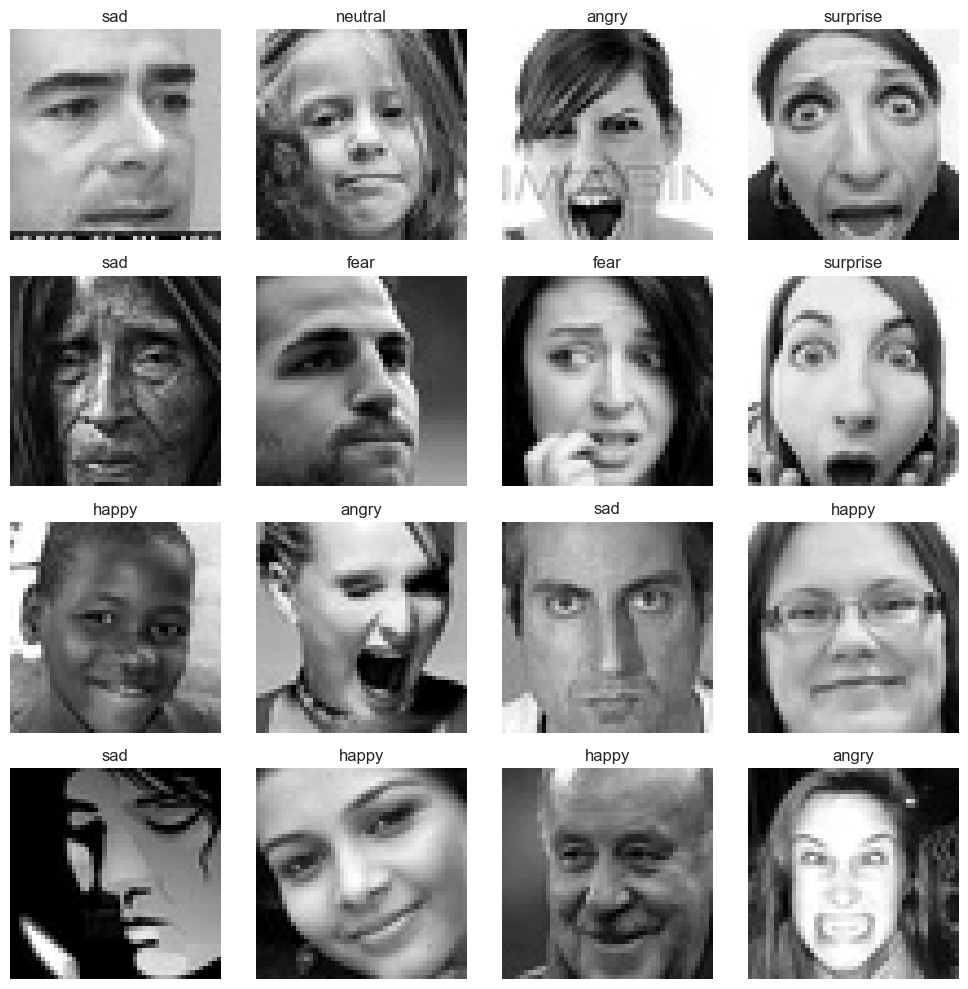

In [48]:
class_names = full_dataset.class_names
plot_random_images(full_dataset, class_names)

Można zauważyć, że przypisana klasa nie zawsze jest intuicyjna z naszego punktu widzenia, z tego powodu zmniejszę ilość grafik selekcjonując te, które najbardziej odzwierciedlają swoją klasę. Zrobię to z pomocą rozwiniętego projektu z poprzedniego semestru z Analizy Danych Multimedialnych "TAGGY".  Korzysta on z modelu "CLIP" dostarczanego przez OpenAI, którego używam z powodu możliwości zadeklarowania własnych klas. Wkleję tutaj jedynie metody wymagane do realizacji planowanego działania.

### Taggy - Detekcja duplikatów

#### HELP:
<code>python .\taggy_cli.py dataset_duplicates --help</code>


Usage: taggy_cli.py dataset_duplicates [OPTIONS]

  Finds and groups duplicate images based on their embedding similarity. Then
  organizes them into subfolders, picking 'best images' if desired.


Options:

-i, --input-dataset-path PATH   Path to the folder containing images.
                                  [required]

-o, --output-folder PATH        Folder to place grouped duplicates.

-l, --labels TEXT               List of labels used for grouping names of
                                  duplicates (if not provided, uses
                                  directories (classes) names ).

-op, --operation [copy|symlink|move]
                                  File operation(s) to perform when grouping
                                  duplicates.

-t, --similarity-threshold FLOAT
                                  Threshold (0..1) for considering images
                                  duplicates.

-b, --propose-best              If provided, proposes 'best' images to keep
                                  in each group.

--help                          Show this message and exit.

#### Użyta komenda:
<code>python .\taggy_cli.py dataset_duplicates -i D:\code\datasets\recognizing_emotions_from_faces\oryginal_data\ -o D:\code\datasets\recognizing_emotions_from_faces\duplicates\ -op copy -t 0.98 -b</code>

#### Wyniki w prezentacji. Wywołanie Taggy trwało ok. godziny (ASUS GTX 1060 3GB)

#### Prezentacja znalezionych duplikatów

In [86]:
import os
from PIL import Image
import time

def create_mosaic(folder, output="mosaic.jpg", thumb_size=(48, 48), per_row=10):
    files = [f for f in os.listdir(folder) if f.lower().endswith(".jpg")]
    imgs = []
    for f in files:
        try:
            img = Image.open(os.path.join(folder, f)).convert("RGB")
            imgs.append(img.resize(thumb_size, resample=Image.Resampling.LANCZOS))
        except Exception:
            pass
    if not imgs:
        return None
    rows = (len(imgs) + per_row - 1) // per_row
    mosaic = Image.new("RGB", (thumb_size[0] * per_row, thumb_size[1] * rows))
    for i, img in enumerate(imgs):
        x = (i % per_row) * thumb_size[0]
        y = (i // per_row) * thumb_size[1]
        mosaic.paste(img, (x, y))
    mosaic.show(os.path.basename(output))
    mosaic.save(output)
    time.sleep(3)
    print("Saved mosaic to", output)
    return mosaic

In [87]:
groups_with_the_most_duplicates = {
    "angry": "angry_20",
    "disgust": "angry_61",
    "fear": "angry_60",
    "happy": "happy_11",
    "neutral": "angry_50",
    "sad": "angry_36",
    "surprise": "angry_84"
    }

In [88]:
for key, value in groups_with_the_most_duplicates.items():
    folder = os.path.join(duplicates_data_path, key, value)
    output = os.path.join(duplicates_data_path, key, f"{key}_example_duplicates.jpg")
    create_mosaic(folder=folder, output=output, thumb_size=(48, 48), per_row=10)

Saved mosaic to D:/code/datasets/recognizing_emotions_from_faces/duplicates\angry\angry_example_duplicates.jpg
Saved mosaic to D:/code/datasets/recognizing_emotions_from_faces/duplicates\disgust\disgust_example_duplicates.jpg
Saved mosaic to D:/code/datasets/recognizing_emotions_from_faces/duplicates\fear\fear_example_duplicates.jpg
Saved mosaic to D:/code/datasets/recognizing_emotions_from_faces/duplicates\happy\happy_example_duplicates.jpg
Saved mosaic to D:/code/datasets/recognizing_emotions_from_faces/duplicates\neutral\neutral_example_duplicates.jpg
Saved mosaic to D:/code/datasets/recognizing_emotions_from_faces/duplicates\sad\sad_example_duplicates.jpg
Saved mosaic to D:/code/datasets/recognizing_emotions_from_faces/duplicates\surprise\surprise_example_duplicates.jpg


Saved mosaic to D:/code/datasets/recognizing_emotions_from_faces/duplicates\happy\happy_example_duplicates.jpg


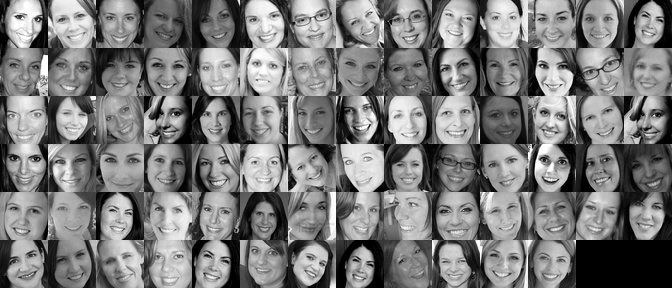

In [94]:
create_mosaic(os.path.join(duplicates_data_path, "happy", groups_with_the_most_duplicates.get("happy")), os.path.join(duplicates_data_path, "happy", "happy_example_duplicates.jpg"), thumb_size=(48, 48), per_row=14)

Saved mosaic to D:/code/datasets/recognizing_emotions_from_faces/duplicates\happy\happy_example_duplicates.jpg


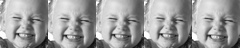

In [98]:
create_mosaic(os.path.join(duplicates_data_path, "happy", "happy_146"), os.path.join(duplicates_data_path, "happy", "happy_example_duplicates.jpg"), thumb_size=(48, 48), per_row=5)

Saved mosaic to D:/code/datasets/recognizing_emotions_from_faces/duplicates\surprise\surprise_example_duplicates.jpg


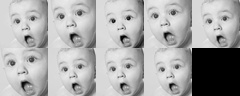

In [100]:
create_mosaic(os.path.join(duplicates_data_path, "surprise", "happy_288"), os.path.join(duplicates_data_path, "surprise", "surprise_example_duplicates.jpg"), thumb_size=(48, 48), per_row=5)

In [116]:
def load_skip_set(json_path):
    """
    Wczytuje plik JSON z folderu [nazwa_klasy] i buduje zbiór znormalizowanych ścieżek plików,
    które mają być pominięte przy kopiowaniu, używając os.path.join.
    """
    try:
        with open(json_path, "r", encoding="utf-8") as f:
            groups = json.load(f)
    except FileNotFoundError:
        print(f"Błąd: Nie znaleziono pliku {json_path}")
        raise
    skip_set = set()
    for group in groups:
        for key in ["images", "best_images"]:
            for item in group.get(key, []):
                path = item.get("path")
                if path:
                    norm_path = os.path.normpath(path)
                    skip_set.add(norm_path)
    return skip_set

In [125]:
def copy_files(source_dir, dest_dir, skip_set):
    """
    Kopiuje wszystkie pliki z katalogu source_dir (rekurencyjnie) do dest_dir,
    pomijając te, których znormalizowane ścieżki znajdują się w skip_set.
    Używa os.path.join oraz os.walk.
    Pliki zapisywane są z rozszerzeniem .jpg. W przypadku konfliktu nazwy dodaje licznik.
    """
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    skipped = 0
    copied = 0
    errors = []

    for root, dirs, files in os.walk(source_dir):
        for file in files:
            file_path = os.path.join(root, file)
            abs_path = os.path.normpath(os.path.abspath(file_path))
            if abs_path in skip_set:
                skipped += 1
                continue

            base_name, _ = os.path.splitext(file)
            dest_file = os.path.join(dest_dir, base_name + ".jpg")
            counter = 1
            while os.path.exists(dest_file):
                dest_file = os.path.join(dest_dir, f"{base_name}_{counter}.jpg")
                counter += 1

            try:
                shutil.copy2(file_path, dest_file)
                copied += 1
            except Exception as e:
                errors.append(f"Błąd kopiowania {file_path}: {e}")

    print(f"[{os.path.basename(source_dir)}]Skopiowano {copied} plików, pominięto {skipped} plików.")

In [130]:
for class_name in groups_with_the_most_duplicates.keys():
    duplicates_class_path = os.path.join(duplicates_data_path, class_name)
    best_images_path = os.path.join(duplicates_class_path, "best_from_duplicates")
    json_path = os.path.join(duplicates_class_path, "grouped_images.json")
    src_path = os.path.join(oryginal_data_path, class_name)
    dest_path = os.path.join(data_without_duplicates_path, class_name)
    skip_set = load_skip_set(json_path)
    copy_files(src_path, dest_path, skip_set)
    print(f"Kopiuję {len(os.listdir(duplicates_class_path))} najlepszych grafik pośród duplikatów dla klasy {class_name}...")
    shutil.copytree(best_images_path, dest_path, dirs_exist_ok=True)
    print("Kopiowanie zakończone dla klasy:", class_name)

[angry]Skopiowano 3881 plików, pominięto 1072 plików.
Kopiuję 376 najlepszych grafik pośród duplikatów dla klasy angry...
Kopiowanie zakończone dla klasy: angry
[disgust]Skopiowano 274 plików, pominięto 273 plików.
Kopiuję 100 najlepszych grafik pośród duplikatów dla klasy disgust...
Kopiowanie zakończone dla klasy: disgust
[fear]Skopiowano 3556 plików, pominięto 1565 plików.
Kopiuję 587 najlepszych grafik pośród duplikatów dla klasy fear...
Kopiowanie zakończone dla klasy: fear
[happy]Skopiowano 8428 plików, pominięto 561 plików.
Kopiuję 267 najlepszych grafik pośród duplikatów dla klasy happy...
Kopiowanie zakończone dla klasy: happy
[neutral]Skopiowano 5488 plików, pominięto 710 plików.
Kopiuję 322 najlepszych grafik pośród duplikatów dla klasy neutral...
Kopiowanie zakończone dla klasy: neutral
[sad]Skopiowano 5018 plików, pominięto 1059 plików.
Kopiuję 420 najlepszych grafik pośród duplikatów dla klasy sad...
Kopiowanie zakończone dla klasy: sad
[surprise]Skopiowano 2309 plików, p

In [131]:
class_name = "happy_98"
duplicates_class_path = os.path.join(duplicates_data_path, class_name)
best_images_path = os.path.join(duplicates_class_path, "best_from_duplicates")
json_path = os.path.join(duplicates_class_path, "grouped_images.json")
src_path = os.path.join(oryginal_data_path, "happy")
dest_path = os.path.join(data_without_duplicates_path, class_name)
skip_set = load_skip_set(json_path)
copy_files(src_path, dest_path, skip_set)
print(f"Kopiuję {len(os.listdir(duplicates_class_path))} najlepszych grafik pośród duplikatów dla klasy {class_name}...")
shutil.copytree(best_images_path, dest_path, dirs_exist_ok=True)
print("Kopiowanie zakończone dla klasy:", class_name)

[happy]Skopiowano 7812 plików, pominięto 1177 plików.
Kopiuję 483 najlepszych grafik pośród duplikatów dla klasy happy_98...
Kopiowanie zakończone dla klasy: happy_98


In [132]:
classes_path = os.walk(data_without_duplicates_path)
print("Ilość \t|\tKlasa")
for root, dirs, files in classes_path:
    if len(files) > 0:
        print(f'{len(files)} \t|\t {os.path.basename(root)}')

Ilość 	|	Klasa
4252 	|	 angry
370 	|	 disgust
4139 	|	 fear
8692 	|	 happy
8289 	|	 happy_98
5806 	|	 neutral
5430 	|	 sad
2997 	|	 surprise


<code>python .\taggy_cli.py class_selection -i D:\code\datasets\recognizing_emotions_from_faces\data_without_duplicates\ -o D:\code\datasets\recognizing_emotions_from_faces\data\ --operation copy --additional-string face</code>


In [134]:
classes_path = os.walk(data_path)
print("Ilość \t|\tKlasa")
for root, dirs, files in classes_path:
    if len(files) > 0:
        print(f'{len(files)} \t|\t {os.path.basename(root)}')

Ilość 	|	Klasa
2500 	|	 angry
370 	|	 disgust
2500 	|	 fear
2500 	|	 happy
2500 	|	 happy_98
2500 	|	 neutral
2500 	|	 sad
2500 	|	 surprise


In [137]:
shutil.rmtree(os.path.join(data_path, "disgust") )

In [138]:
shutil.rmtree(os.path.join(data_path, "happy_98") )

In [139]:
classes_path = os.walk(data_path)
print("Ilość \t|\tKlasa")
for root, dirs, files in classes_path:
    if len(files) > 0:
        print(f'{len(files)} \t|\t {os.path.basename(root)}')

Ilość 	|	Klasa
2500 	|	 angry
2500 	|	 fear
2500 	|	 happy
2500 	|	 neutral
2500 	|	 sad
2500 	|	 surprise


In [140]:
full_dataset = image_dataset_from_directory(
                                      data_path,
                                      image_size=(48, 48),
                                      label_mode='categorical',
                                      color_mode="grayscale",
                                      )

Found 15000 files belonging to 6 classes.


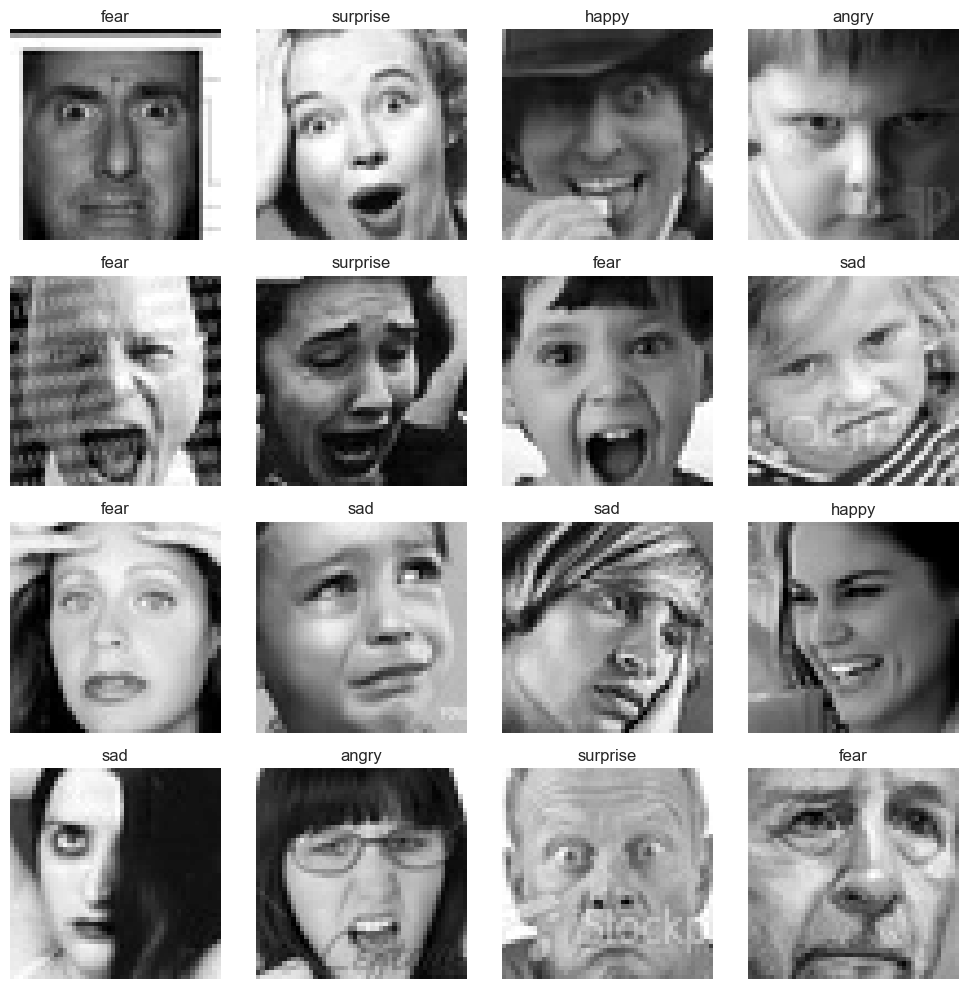

In [141]:
class_names = full_dataset.class_names
plot_random_images(full_dataset, class_names)D

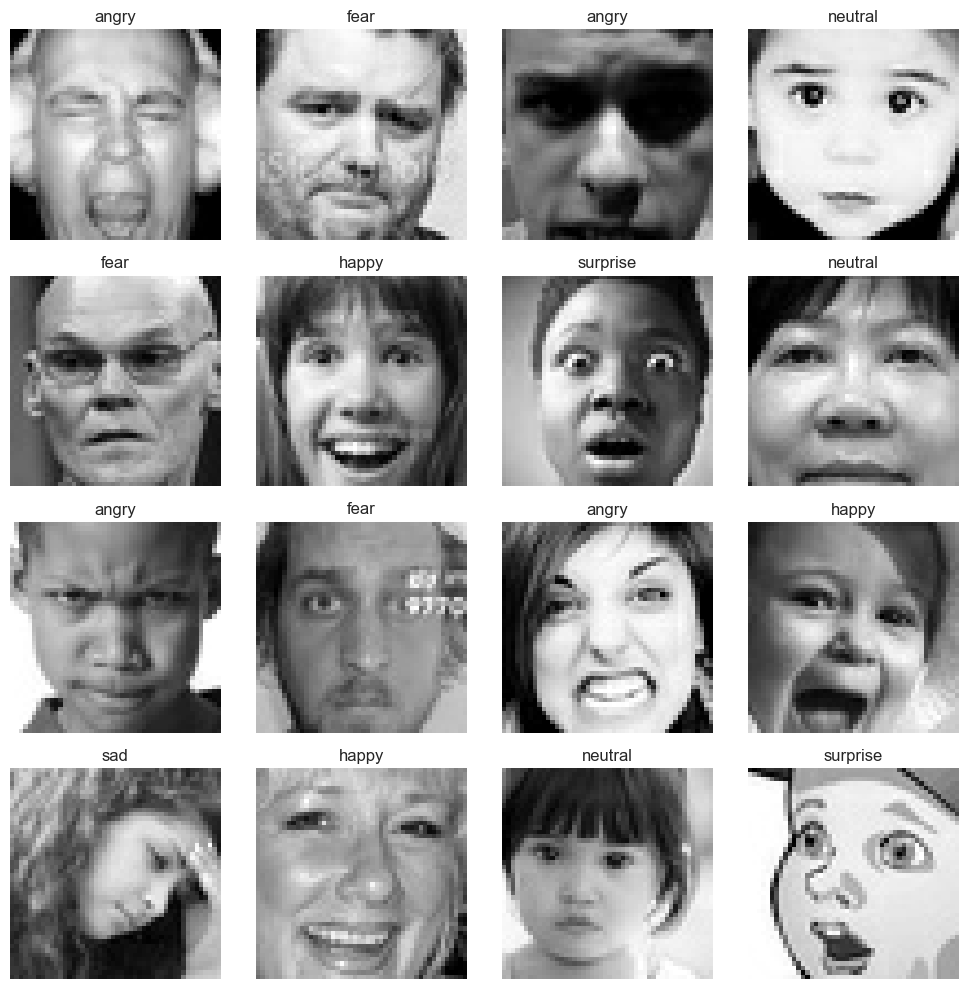

In [142]:
class_names = full_dataset.class_names
plot_random_images(full_dataset, class_names)